# Exercise 1.4

## Classification of CIFAR10 images
### Optimizers
In this exercise we will classify the images from the CIFAR10 dataset. We will use different optimizers and compare their convergence speed. First we import the libraries that we need.

**NB! The exercise is formulated in a Jupyter notebook for ease of communication, but you should feel *very* free to carry out the entire exercise without the notebook. If you do carry it out in a notebook, please finish by migrating your code over to a script that you can run from the terminal**

In [81]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [82]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In this exercise we will classify images from the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 
CIFAR10 has 60000 colour images of size 32x32 equally distributed in 10 classes.
* You should load this dataset (hint: it is a built-in dataset in pytorch).

In [83]:
batch_size = 128
trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
from torchvision.utils import make_grid

def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

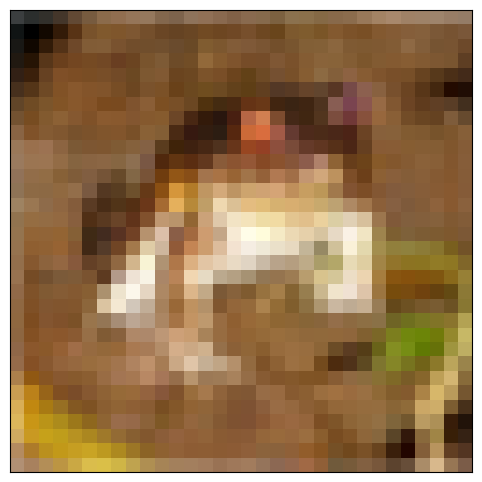

In [85]:
show_batch(trainset)

* Make a CNN to train on the CIFAR10 dataset

In [105]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(2, 2), 
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.Softmax(dim=1)
                )

        self.fully_connected = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(16*16*16, 500),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
        
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [106]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(torch.log(output), target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [101]:
model = Network()
model.to(device)

#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

 * Train the network and plot make a plot of the loss and accuracy for both training and with the epoch on the x-axis

In [109]:
out_dict = train(model, optimizer)


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 10.1%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.304	 Accuracy train: 9.9%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.304	 Accuracy train: 10.2%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 10.0%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 9.9%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 9.9%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.303	 Accuracy train: 10.1%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.303	 test: 2.304	 Accuracy train: 10.1%	 test: 10.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.304	 test: 2.303	 Accuracy train: 9.8%	 test: 10.0%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.060	 test: 1.984	 Accuracy train: 23.3%	 test: 28.5%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.639	 test: 1.499	 Accuracy train: 39.6%	 test: 44.6%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.463	 test: 1.546	 Accuracy train: 46.7%	 test: 44.2%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.372	 test: 1.985	 Accuracy train: 50.3%	 test: 35.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.318	 test: 1.518	 Accuracy train: 52.2%	 test: 45.5%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.266	 test: 1.230	 Accuracy train: 54.4%	 test: 56.2%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.220	 test: 1.154	 Accuracy train: 56.2%	 test: 58.6%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.181	 test: 1.168	 Accuracy train: 57.6%	 test: 58.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.151	 test: 1.088	 Accuracy train: 59.0%	 test: 60.9%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.120	 test: 1.291	 Accuracy train: 60.1%	 test: 56.4%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.981	 test: 1.798	 Accuracy train: 26.1%	 test: 33.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.781	 test: 1.491	 Accuracy train: 33.6%	 test: 46.8%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.677	 test: 1.391	 Accuracy train: 37.8%	 test: 52.4%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.631	 test: 1.416	 Accuracy train: 39.4%	 test: 49.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.596	 test: 1.405	 Accuracy train: 40.9%	 test: 48.9%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.573	 test: 1.354	 Accuracy train: 41.7%	 test: 52.8%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.557	 test: 1.304	 Accuracy train: 42.6%	 test: 53.8%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.546	 test: 1.319	 Accuracy train: 42.8%	 test: 53.7%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.529	 test: 1.265	 Accuracy train: 43.8%	 test: 56.2%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.531	 test: 1.309	 Accuracy train: 43.8%	 test: 55.4%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.996	 test: 1.817	 Accuracy train: 25.5%	 test: 32.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.547	 test: 1.389	 Accuracy train: 43.4%	 test: 49.4%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.425	 test: 1.636	 Accuracy train: 48.8%	 test: 42.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.352	 test: 1.310	 Accuracy train: 51.5%	 test: 53.6%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.293	 test: 1.229	 Accuracy train: 53.4%	 test: 55.1%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.253	 test: 1.226	 Accuracy train: 54.8%	 test: 55.9%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.213	 test: 1.141	 Accuracy train: 56.5%	 test: 59.2%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.182	 test: 1.192	 Accuracy train: 57.7%	 test: 57.4%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.152	 test: 1.113	 Accuracy train: 58.7%	 test: 59.5%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.124	 test: 1.089	 Accuracy train: 60.1%	 test: 60.9%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 2.021	 test: 1.709	 Accuracy train: 23.9%	 test: 37.3%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.824	 test: 1.631	 Accuracy train: 30.4%	 test: 39.5%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.779	 test: 1.564	 Accuracy train: 31.3%	 test: 41.0%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.749	 test: 1.481	 Accuracy train: 32.8%	 test: 46.7%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.722	 test: 1.497	 Accuracy train: 33.7%	 test: 45.7%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.712	 test: 1.424	 Accuracy train: 33.9%	 test: 48.4%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.699	 test: 1.430	 Accuracy train: 34.3%	 test: 47.4%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.698	 test: 1.397	 Accuracy train: 34.3%	 test: 50.9%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.686	 test: 1.358	 Accuracy train: 34.7%	 test: 50.5%


  0%|          | 0/391 [00:00<?, ?it/s]

Loss train: 1.676	 test: 1.374	 Accuracy train: 35.1%	 test: 52.3%


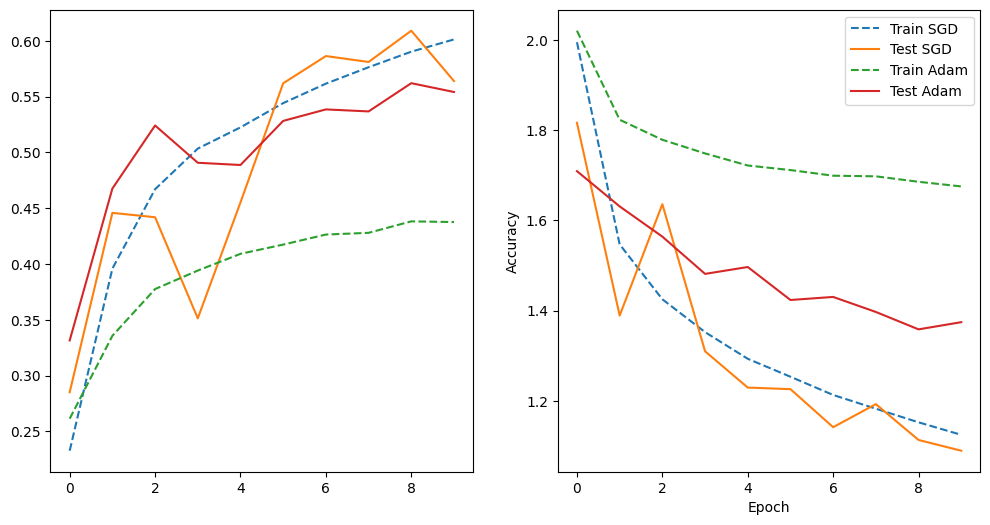

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for opt in ['SGD', 'Adam']:
    model = Network()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    if opt == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    out_dict = train(model, optimizer)
    ax[0].plot(out_dict['train_acc'], label=f'Train {opt}', linestyle='--')
    ax[0].plot(out_dict['test_acc'], label=f'Test {opt}', linestyle='-')

for opt in ['SGD', 'Adam']:
    model = Network()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    if opt == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    out_dict = train(model, optimizer)
    ax[1].plot(out_dict['train_loss'], label=f'Train {opt}', linestyle='--')
    ax[1].plot(out_dict['test_loss'], label=f'Test {opt}', linestyle='-')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()



* Discuss what you see. Are you overfitting to the training data? Do you not learn anything? What can you change to do better?

* Repeat the above steps but using Adam as the optimizer. Use Pytorch's defaults parameters. Do you learn faster?
* Which optimizer works best for you?
* Plot the test and test errors for both SGD and Adam in one plot
* Try adding Batch normalisation after your convolutional layers. Does it help?

## ResNet

Now you will create and train a ResNet.
* Implement the Residual block as a network below using convolutional kernel size $3\times3$ according to the figure below
![Residual block](https://cdn-images-1.medium.com/max/800/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        ...
    def forward(self, x):
        ...
        return out

The following code is a sanity of your residual block network

In [ ]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
assert(len(res_block.state_dict())==4)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

We define a network that uses your `ResNetBlock`

In [ ]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(32*32*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.res_blocks(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

Let's train our new ResNet!

In [ ]:
model = ResNet(3, 8)
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
out_dict = train(model, optimizer)



Do you get nan loss at some point during training? 
This can be caused by the numerical instability of using softmax and log as two functions. 
* Change your network and loss to use a layer that combines the softmax log into one such as `nn.LogSoftmax`. You can also use `nn.CrossEntropyLoss` which also integrates `nn.NLLLoss`.